# Lecture : Graph Generation Models

## Lab 01 : Variational autoencoders (VAE) for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.1.2.post4
cpu


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 640x480 with 0 Axes>

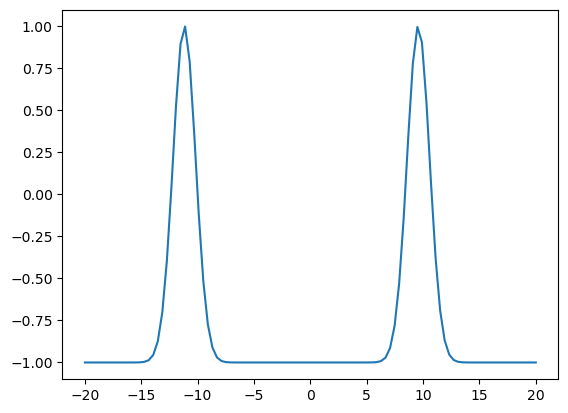

<Figure size 640x480 with 0 Axes>

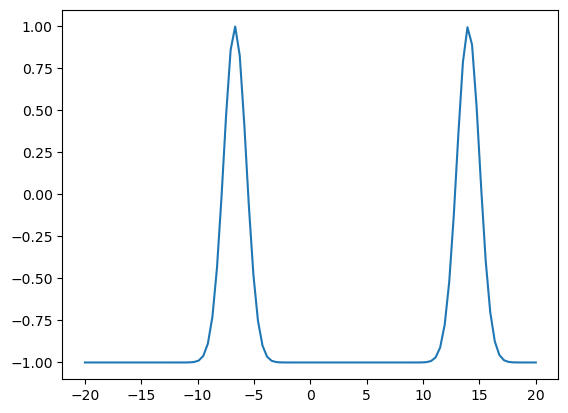

In [6]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# VAE [1] with Transformers [2]

[1] Kingma, Welling, Auto-Encoding Variational Bayes, 2013, https://arxiv.org/pdf/1312.6114  
[2] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762


In [7]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 32 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_encoder = 2 # number of transformer encoder layers
num_layers_decoder = 2 # number of transformer decoder layers
drop = 0.01 # dropout value
bs = 50 # batch size
print('dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs : ', \
      dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs :  32 4 128 2 2 0.01 50


# Question 1: Design vanilla Transformers

#### Step 1: Code single-head attention layer in ```class head_attention(nn.Module)```. The formula is 
\begin{eqnarray*}
&&\quad\quad\ \textrm{Attention}(h)=\textrm{Softmax}\left(\frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d\_head}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d\_head}, W_Q, W_K, W_V\in \mathbb{R}^{d\times d\_head}
\end{eqnarray*}

- In this code, we consider a batch of data $x\in\mathbb{R}^{B\times N\times d}$. Process the correct dimension when calculating attention.
- We also employ one ```nn.Dropout()``` on the attention score matrix.

#### Step 2: Construct the multi-head attention layer in ```class MHA(nn.Module)``` by concatenating multiple ```head_attention```. 
\begin{eqnarray*}
\textrm{MHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{Attention}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d\_head}, W_O\in \mathbb{R}^{d\times d} \\
\end{eqnarray*}

- One dropout layer is needed upon the output node embeddings.

#### Step 3: Implement a complete Transformer block in ```class BlockGT(nn.Module)``` following:
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{MHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}
\end{eqnarray*}

- Notice the positions of the two layer normalization layers.
  

In [18]:
# Define VAE architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)     # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
    def forward(self, x):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x


Number of parameters: 885057 (0.89 million)
batch_x0 torch.Size([50, 100])
batch_x_pred torch.Size([50, 100])
batch_x_gen torch.Size([4, 100])


# Question 2: Implement the VAE architecture

#### Step 1: Initialize encoder and decoder networks using above ```BlockGT```.

#### Step 2: Encode the input as a distribution.

For the training phase
- Get the embedding for each data point via the encoder network.
- Average these embeddings to get one vector to represent the whole input data.
- Employ two MLPs on the data representation to get the mean vector and the log variance vector, separately.
- Use the re-parameterization trick to get one sample ```z``` from the distribution (defined by got mean and log variance vectors).
  
For generation phase, directly sample ```z``` from the normal distribution. Use [torch.Tensor.normal_()](https://pytorch.org/docs/stable/generated/torch.Tensor.normal_.html#torch.Tensor.normal_).

#### Step 3: Decode the hidden ```z``` into the original space.
- In this code, the dimensions of `z` and `h` are not same. So, an additional MLP is required to map `z` to `h`.
- If positional encoding (PE) is a part of input for generator, we also input the same dimensions of PE into the decoder.
  

In [ ]:
class VAE(nn.Module): 
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.h_emb = nn.Linear(1, d)
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        self.gt_enc_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_encoder)] )
        self.gt_dec_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_decoder)] )
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
        self.linear_q_mu     = nn.Linear(d, dz)
        self.linear_q_logvar = nn.Linear(d, dz)
        self.linear_p = nn.Linear(dz, d) 
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, h, train=True, num_gen=1):
        if train: # training phase
            # input layer
            h = self.h_emb(h.unsqueeze(2))                    # [bs, n, d]
            bs2 = h.size(0)
            pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                            # [bs, n, d] 
            h = h + pe_x                                      # [bs, n, d]
            # encoder
            ###############################################
            # According to Step 2, finish encoding process
            # YOUR CODE STARTS
            ###############################################
            for gt_enc_layer in self.gt_enc_layers:
                h = gt_enc_layer(h)                           # [bs, n, d]
            # data representation
            h_token = h[:,:n,:].mean(1)                       # [bs, d]
            # VAE Gaussian
            q_mu = self.linear_q_mu(h_token)                  # [bs, dz]
            q_logvar = self.linear_q_logvar(h_token)          # [bs, dz]
            q_std = torch.exp(0.5*q_logvar)                   # [bs, dz]
            eps = torch.randn_like(q_std)                     # [bs, dz]
            z = q_mu + eps * q_std                            # [bs, dz]
            ###############################################
            # YOUR CODE ENDS
            ###############################################
            bs_dec = bs
        else: # generation phase
            bs_dec = num_gen
            pe_x = torch.arange(0,n).to(device).repeat(bs_dec,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                               # [bs, n, d] 
            ###############################################
            # Directly sample `z` from normal distribution, the shape is [number of samples to generate, hidden dimension of `z`]
            # YOUR CODE STARTS
            ###############################################
            z = torch.Tensor(num_gen, dz).normal_(mean=0.0, std=1.0).to(device) # [b, dz]
            ###############################################
            # YOUR CODE ENDS
            ###############################################
            q_mu, q_logvar = _, _
        # decoder
        ###############################################
        # According to Step 3, finish decoding process
        # YOUR CODE STARTS
        ###############################################
        z = self.linear_p(z).view(bs_dec, 1, d)              # [bs, 1, d] 
        h = z + pe_x[:bs_dec, :, :]                          # [bs, n, d] 
        for gt_dec_layer in self.gt_dec_layers:
            h = gt_dec_layer(h)                              # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output
        h = self.ln_final(h)                                 # [bs, n, d]
        h = self.linear_final(h).squeeze()                   # [bs, n]
        return h, q_mu, q_logvar


# Instantiate the network
net = VAE()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)
idx_data = torch.LongTensor(bs).random_(0,N)
batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
print('batch_x0',batch_x0.size())
batch_x_pred, q_mu, q_logvar = net(batch_x0) # [bs, n]
print('batch_x_pred',batch_x_pred.size())
loss_data = torch.nn.MSELoss()(batch_x_pred, batch_x0)
loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
loss_VAE = 1* loss_data + loss_KL
loss = loss_VAE
optimizer.zero_grad()
loss.backward()
optimizer.step()

# generate new data
with torch.no_grad():
    num_data = 4
    batch_x_gen = net(None, False, num_data)[0] # [num_data, n]
    print('batch_x_gen',batch_x_gen.size())

# Question 3: Code training loss of VAE

The loss includes fidelity loss and regularization loss
\begin{eqnarray*}
&&\textrm{Fidelity Loss: } \max_{\theta, \phi}\mathbb{E}_{z\sim q_\phi(z|x)} (\log p_\theta(x|z))=\min\limits_{\theta, \phi} \textrm{MSE}(x, \hat{x})\\
&&\textrm{Regularization loss: } -KL(q_\phi(z|x), p(z))=\frac{1}{2}\sum\limits_{j=1}^{d_z}(1+(\log\sigma^2_{z|x})_j-(\mu_{z|x})^2_j-(\sigma^2_{z|x})_j)
\end{eqnarray*}


Number of parameters: 885057 (0.89 million)
epoch= 0 	 time= 0.0414 min 	 lr= 0.0003 	 loss= 3.0483
epoch= 1 	 time= 0.0825 min 	 lr= 0.0003 	 loss= 2.4875
epoch= 2 	 time= 0.1222 min 	 lr= 0.0003 	 loss= 2.4668
epoch= 3 	 time= 0.1672 min 	 lr= 0.0003 	 loss= 2.4546
epoch= 4 	 time= 0.2154 min 	 lr= 0.0003 	 loss= 2.4470
epoch= 5 	 time= 0.2608 min 	 lr= 0.0003 	 loss= 2.4416
epoch= 6 	 time= 0.3074 min 	 lr= 0.0003 	 loss= 2.4367
epoch= 7 	 time= 0.3536 min 	 lr= 0.0003 	 loss= 2.4019
epoch= 8 	 time= 0.3971 min 	 lr= 0.0003 	 loss= 2.1399
epoch= 9 	 time= 0.4365 min 	 lr= 0.0003 	 loss= 1.9542
epoch= 10 	 time= 0.4798 min 	 lr= 0.0003 	 loss= 1.6346


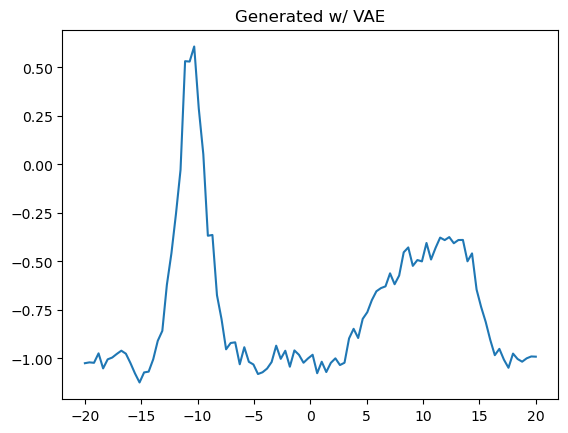

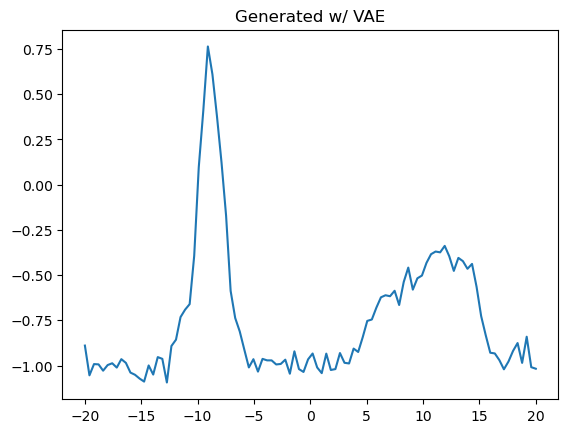

epoch= 11 	 time= 0.5345 min 	 lr= 0.0003 	 loss= 1.4524
epoch= 12 	 time= 0.5760 min 	 lr= 0.0003 	 loss= 1.3829
epoch= 13 	 time= 0.6164 min 	 lr= 0.0003 	 loss= 1.2195
epoch= 14 	 time= 0.6596 min 	 lr= 0.0003 	 loss= 0.9725
epoch= 15 	 time= 0.7007 min 	 lr= 0.0003 	 loss= 0.7762
epoch= 16 	 time= 0.7426 min 	 lr= 0.0003 	 loss= 0.5607
epoch= 17 	 time= 0.7844 min 	 lr= 0.0003 	 loss= 0.5046
epoch= 18 	 time= 0.8316 min 	 lr= 0.0003 	 loss= 0.4442
epoch= 19 	 time= 0.8780 min 	 lr= 0.0003 	 loss= 0.3821
epoch= 20 	 time= 0.9201 min 	 lr= 0.0003 	 loss= 0.3701


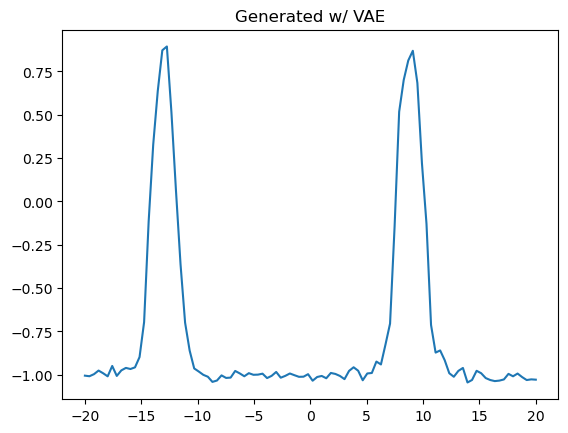

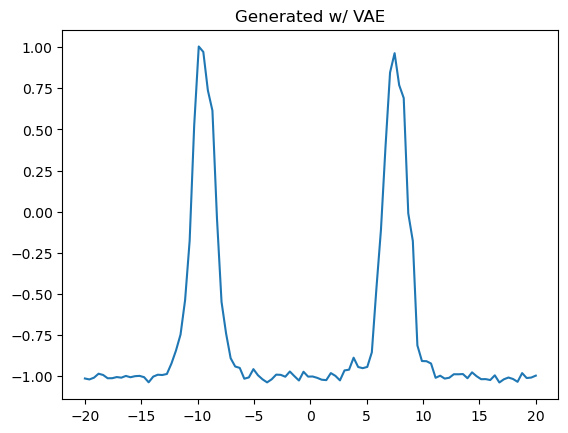

epoch= 21 	 time= 0.9696 min 	 lr= 0.0003 	 loss= 0.3233
epoch= 22 	 time= 1.0082 min 	 lr= 0.0003 	 loss= 0.3226
epoch= 23 	 time= 1.0510 min 	 lr= 0.0003 	 loss= 0.3128
epoch= 24 	 time= 1.0947 min 	 lr= 0.0003 	 loss= 0.3045
epoch= 25 	 time= 1.1383 min 	 lr= 0.0003 	 loss= 0.2900
epoch= 26 	 time= 1.1802 min 	 lr= 0.0003 	 loss= 0.2869
epoch= 27 	 time= 1.2222 min 	 lr= 0.0003 	 loss= 0.2889
epoch= 28 	 time= 1.2621 min 	 lr= 0.000285 	 loss= 0.2900
epoch= 29 	 time= 1.3037 min 	 lr= 0.000285 	 loss= 0.2867
epoch= 30 	 time= 1.3454 min 	 lr= 0.000285 	 loss= 0.2894


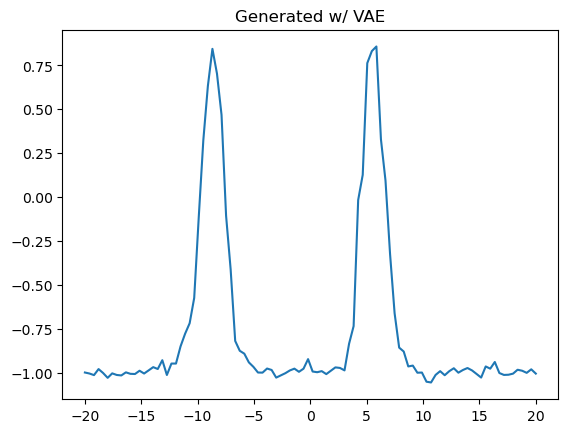

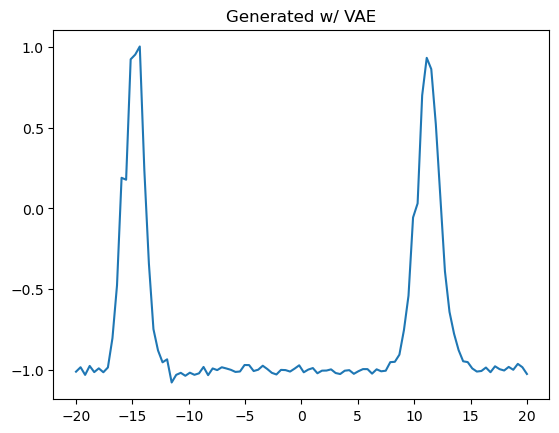

epoch= 31 	 time= 1.3900 min 	 lr= 0.000285 	 loss= 0.2781
epoch= 32 	 time= 1.4321 min 	 lr= 0.000285 	 loss= 0.2796
epoch= 33 	 time= 1.4735 min 	 lr= 0.000285 	 loss= 0.2751
epoch= 34 	 time= 1.5166 min 	 lr= 0.000285 	 loss= 0.2738
epoch= 35 	 time= 1.5570 min 	 lr= 0.000285 	 loss= 0.2675
epoch= 36 	 time= 1.5910 min 	 lr= 0.000285 	 loss= 0.2725
epoch= 37 	 time= 1.6325 min 	 lr= 0.000285 	 loss= 0.2670
epoch= 38 	 time= 1.6722 min 	 lr= 0.000285 	 loss= 0.2729
epoch= 39 	 time= 1.7126 min 	 lr= 0.000285 	 loss= 0.2655
epoch= 40 	 time= 1.7512 min 	 lr= 0.000285 	 loss= 0.2690


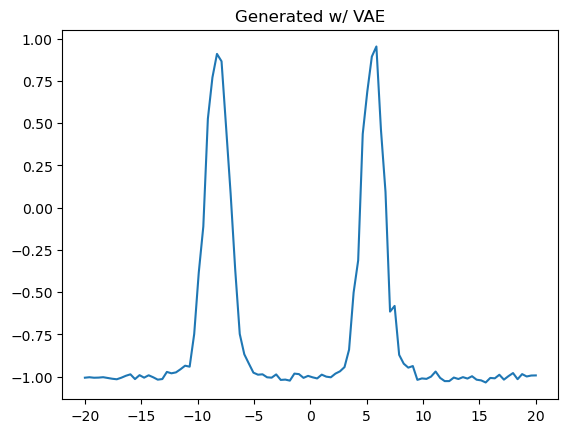

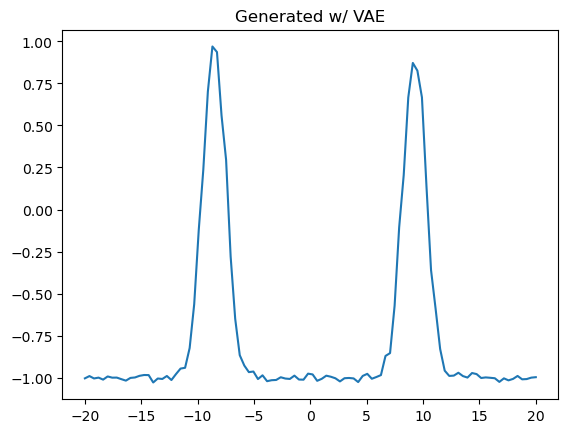

epoch= 41 	 time= 1.7886 min 	 lr= 0.00027075 	 loss= 0.2750
epoch= 42 	 time= 1.8332 min 	 lr= 0.00027075 	 loss= 0.2633
epoch= 43 	 time= 1.8773 min 	 lr= 0.00027075 	 loss= 0.2596
epoch= 44 	 time= 1.9194 min 	 lr= 0.00027075 	 loss= 0.2584
epoch= 45 	 time= 1.9614 min 	 lr= 0.00027075 	 loss= 0.2664
epoch= 46 	 time= 2.0135 min 	 lr= 0.0002572125 	 loss= 0.2597
epoch= 47 	 time= 2.0608 min 	 lr= 0.0002572125 	 loss= 0.2592
epoch= 48 	 time= 2.1075 min 	 lr= 0.000244351875 	 loss= 0.2603
epoch= 49 	 time= 2.1545 min 	 lr= 0.000244351875 	 loss= 0.2514
epoch= 50 	 time= 2.1965 min 	 lr= 0.000244351875 	 loss= 0.2577


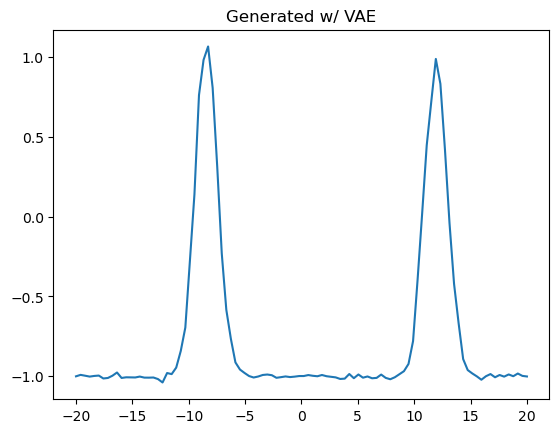

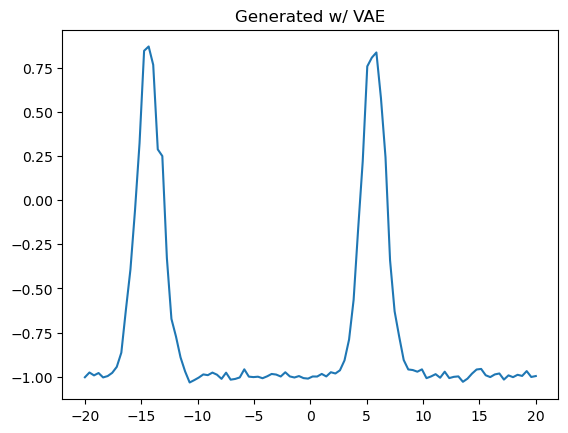

epoch= 51 	 time= 2.2460 min 	 lr= 0.00023213428124999998 	 loss= 0.2584
epoch= 52 	 time= 2.2878 min 	 lr= 0.00023213428124999998 	 loss= 0.2534
epoch= 53 	 time= 2.3273 min 	 lr= 0.00022052756718749997 	 loss= 0.2523
epoch= 54 	 time= 2.3667 min 	 lr= 0.00022052756718749997 	 loss= 0.2515
epoch= 55 	 time= 2.4113 min 	 lr= 0.00020950118882812497 	 loss= 0.2519
epoch= 56 	 time= 2.4519 min 	 lr= 0.00020950118882812497 	 loss= 0.2514
epoch= 57 	 time= 2.4981 min 	 lr= 0.00020950118882812497 	 loss= 0.2561
epoch= 58 	 time= 2.5443 min 	 lr= 0.00019902612938671872 	 loss= 0.2526
epoch= 59 	 time= 2.5913 min 	 lr= 0.00019902612938671872 	 loss= 0.2533
epoch= 60 	 time= 2.6379 min 	 lr= 0.00019902612938671872 	 loss= 0.2467


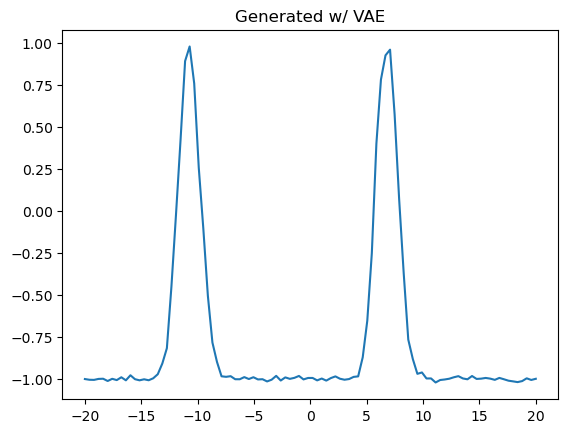

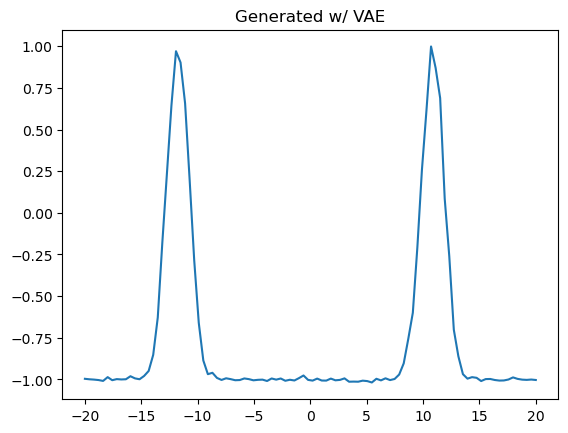

epoch= 61 	 time= 2.6885 min 	 lr= 0.00019902612938671872 	 loss= 0.2518
epoch= 62 	 time= 2.7343 min 	 lr= 0.00018907482291738277 	 loss= 0.2469
epoch= 63 	 time= 2.7810 min 	 lr= 0.00018907482291738277 	 loss= 0.2451
epoch= 64 	 time= 2.8280 min 	 lr= 0.00018907482291738277 	 loss= 0.2522
epoch= 65 	 time= 2.8742 min 	 lr= 0.0001796210817715136 	 loss= 0.2486
epoch= 66 	 time= 2.9169 min 	 lr= 0.0001796210817715136 	 loss= 0.2427
epoch= 67 	 time= 2.9634 min 	 lr= 0.0001796210817715136 	 loss= 0.2460
epoch= 68 	 time= 3.0105 min 	 lr= 0.00017064002768293793 	 loss= 0.2464
epoch= 69 	 time= 3.0569 min 	 lr= 0.00017064002768293793 	 loss= 0.2464
epoch= 70 	 time= 3.1032 min 	 lr= 0.00016210802629879103 	 loss= 0.2429


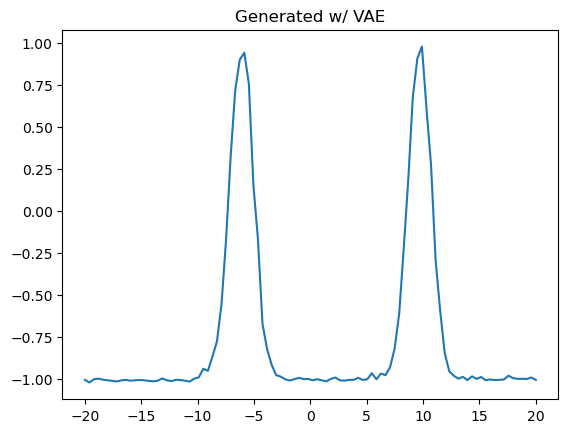

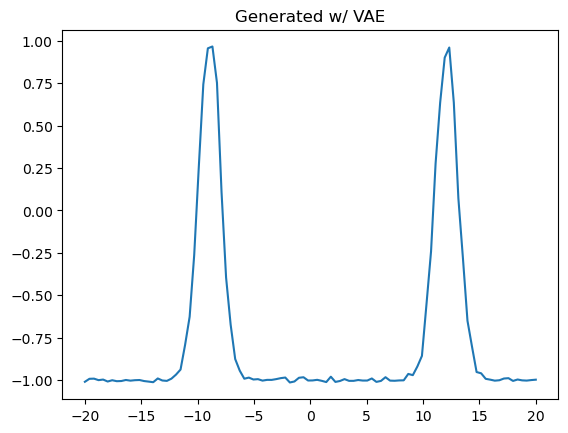

epoch= 71 	 time= 3.1587 min 	 lr= 0.00016210802629879103 	 loss= 0.2462
epoch= 72 	 time= 3.2086 min 	 lr= 0.00016210802629879103 	 loss= 0.2405
epoch= 73 	 time= 3.2547 min 	 lr= 0.00016210802629879103 	 loss= 0.2438
epoch= 74 	 time= 3.3011 min 	 lr= 0.00015400262498385146 	 loss= 0.2430
epoch= 75 	 time= 3.3471 min 	 lr= 0.00015400262498385146 	 loss= 0.2434
epoch= 76 	 time= 3.3952 min 	 lr= 0.00015400262498385146 	 loss= 0.2399
epoch= 77 	 time= 3.4430 min 	 lr= 0.00015400262498385146 	 loss= 0.2430
epoch= 78 	 time= 3.4896 min 	 lr= 0.00014630249373465888 	 loss= 0.2438
epoch= 79 	 time= 3.5366 min 	 lr= 0.00014630249373465888 	 loss= 0.2439
epoch= 80 	 time= 3.5836 min 	 lr= 0.00013898736904792593 	 loss= 0.2417


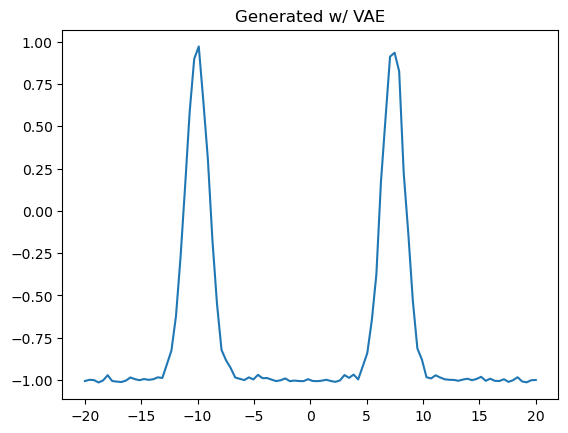

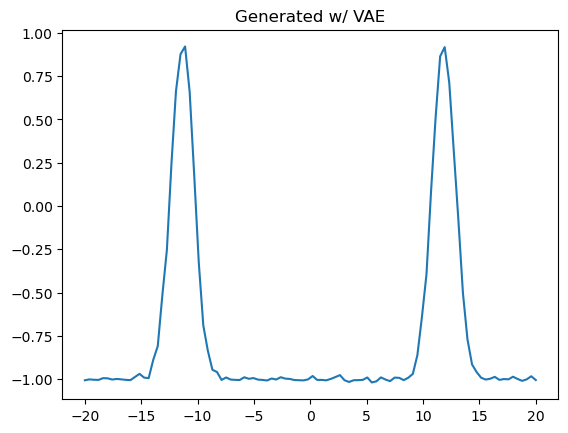

epoch= 81 	 time= 3.6341 min 	 lr= 0.00013898736904792593 	 loss= 0.2407
epoch= 82 	 time= 3.6807 min 	 lr= 0.00013898736904792593 	 loss= 0.2395
epoch= 83 	 time= 3.7278 min 	 lr= 0.00013898736904792593 	 loss= 0.2433
epoch= 84 	 time= 3.7744 min 	 lr= 0.00013203800059552963 	 loss= 0.2403
epoch= 85 	 time= 3.8213 min 	 lr= 0.00013203800059552963 	 loss= 0.2421
epoch= 86 	 time= 3.8679 min 	 lr= 0.00012543610056575314 	 loss= 0.2414
epoch= 87 	 time= 3.9144 min 	 lr= 0.00012543610056575314 	 loss= 0.2379
epoch= 88 	 time= 3.9610 min 	 lr= 0.00012543610056575314 	 loss= 0.2380
epoch= 89 	 time= 4.0079 min 	 lr= 0.00011916429553746547 	 loss= 0.2390
epoch= 90 	 time= 4.0545 min 	 lr= 0.00011916429553746547 	 loss= 0.2382


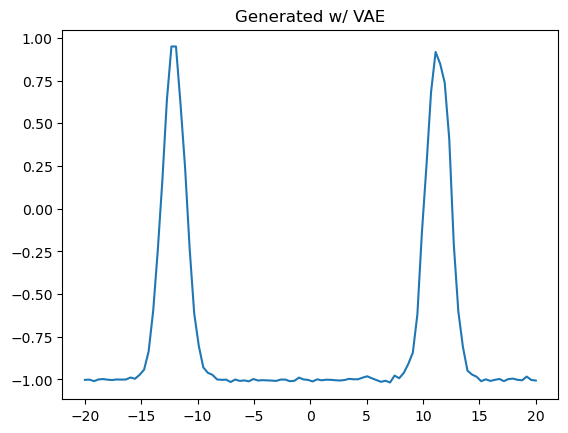

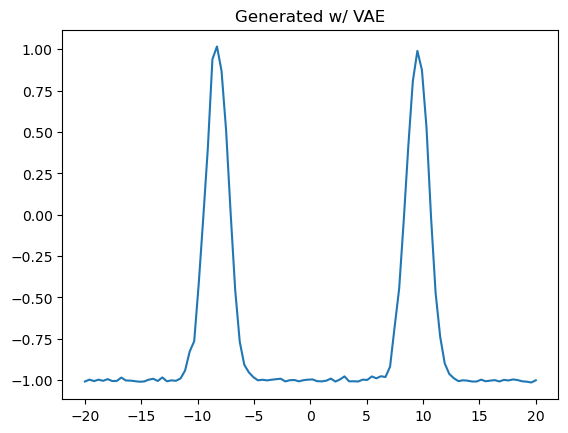

epoch= 91 	 time= 4.1099 min 	 lr= 0.0001132060807605922 	 loss= 0.2395
epoch= 92 	 time= 4.1599 min 	 lr= 0.0001132060807605922 	 loss= 0.2384
epoch= 93 	 time= 4.2112 min 	 lr= 0.00010754577672256258 	 loss= 0.2401
epoch= 94 	 time= 4.2596 min 	 lr= 0.00010754577672256258 	 loss= 0.2364
epoch= 95 	 time= 4.3117 min 	 lr= 0.00010754577672256258 	 loss= 0.2383
epoch= 96 	 time= 4.3647 min 	 lr= 0.00010216848788643445 	 loss= 0.2384
epoch= 97 	 time= 4.4167 min 	 lr= 0.00010216848788643445 	 loss= 0.2385
epoch= 98 	 time= 4.4687 min 	 lr= 9.706006349211273e-05 	 loss= 0.2364

 lr is equal to min lr -- training stopped



In [19]:
# Training loop
del net
net = VAE()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 100
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        idx_data = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_data,:].to(device) # [bs, n]
        batch_x_pred, q_mu, q_logvar = net(batch_x0) # [bs, n]     
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        loss_data = torch.nn.MSELoss()(batch_x_pred, batch_x0)
        loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        loss_VAE = 10 * loss_data + loss_KL 
        loss = loss_VAE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    scheduler.step(mean_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', str(elapsed)[:6],'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', str(mean_loss)[:6] )

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        x_fake = net(None, False, 2)[0]
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ VAE"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ VAE"); plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-4: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Question 4: Generate new data

Hint: use the VAE model `net()`, set `train` as False, and set `num_gen` as the number of generative samples.


batch_x_0 torch.Size([16, 100])


<Figure size 1280x960 with 0 Axes>

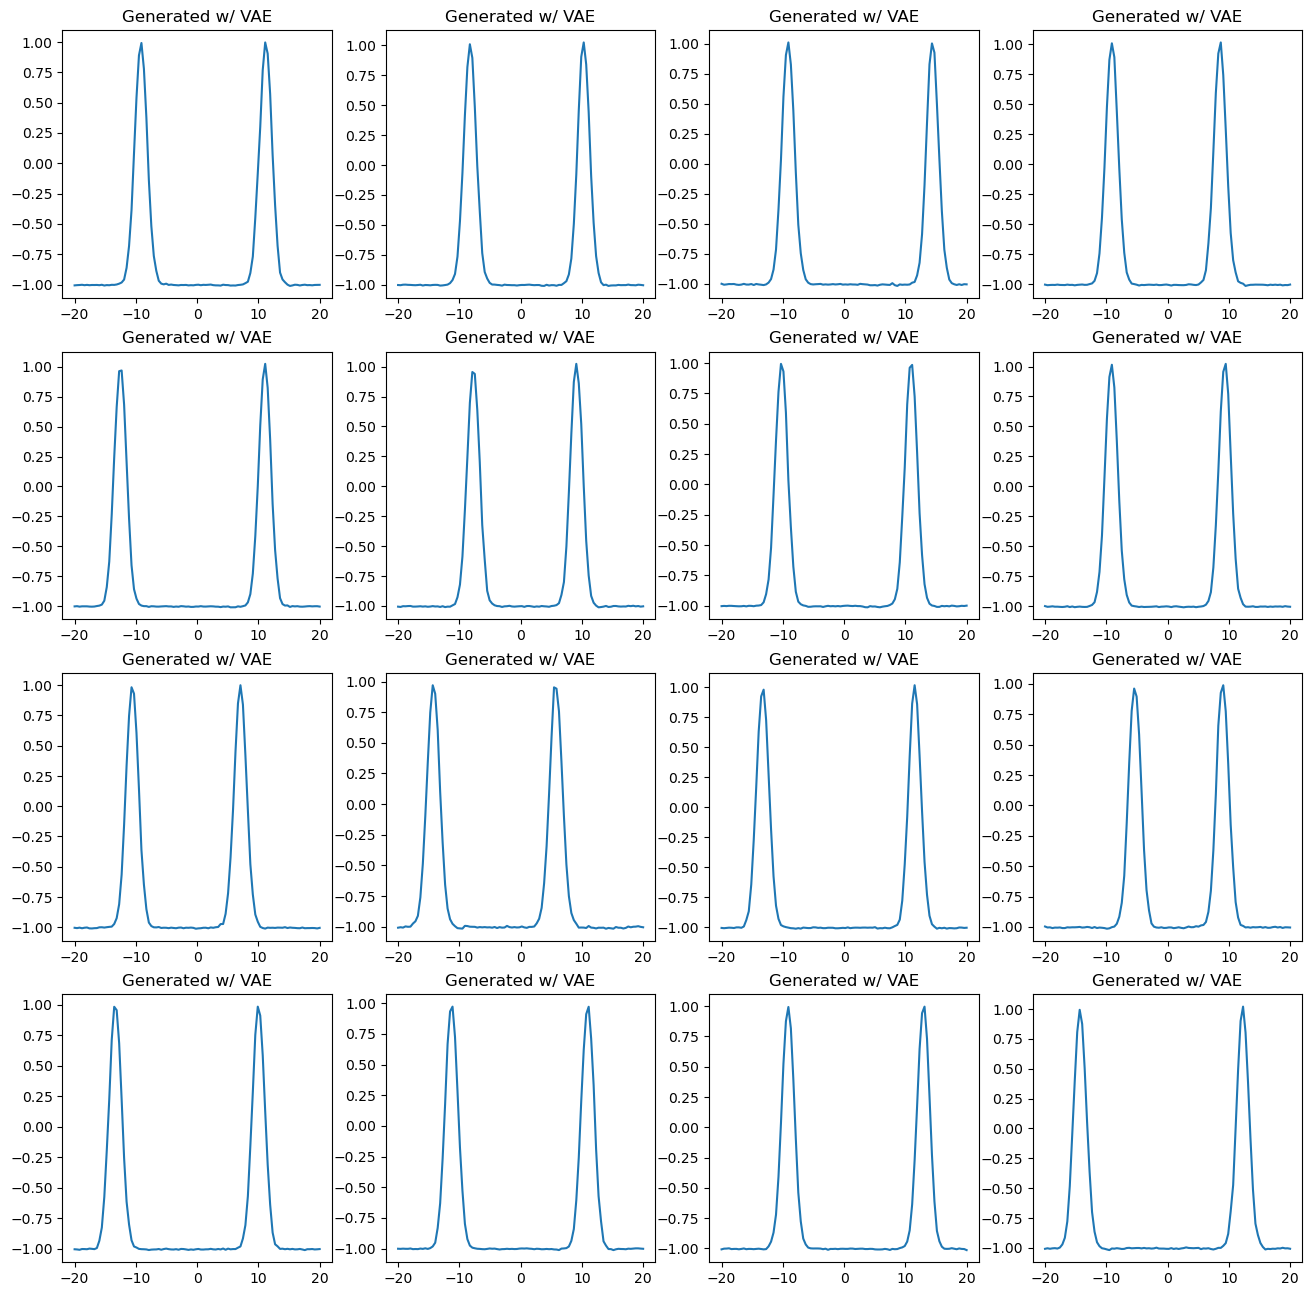

In [21]:
net.eval()
with torch.no_grad():
    num_generated_images = 16   
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    batch_x_0 = net(None, False, num_generated_images)[0]
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ VAE")
plt.show()
